<a href="https://colab.research.google.com/github/HusseinBitambuka/maize-images-classification/blob/main/maize_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rarfile


In [43]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from google.colab import drive
import shutil
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc
from concurrent.futures import ThreadPoolExecutor


In [ ]:

drive.mount('/content/drive/')

Mounted at /content/drive/


In [32]:

def load_data(parent_folder, width, height):
    images = []
    labels = []
    label_map = {'Healthy_1': 0, 'Healthy_2': 0,
                 'MLB_1': 1, 'MLB_2': 1,
                 'MSV_1': 2, 'MSV_2': 2}

    # Define a thread pool executor with a limited number of workers
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = []

        # Iterate through each subfolder in the parent folder
        for folder_name in os.listdir(parent_folder):
            folder_path = os.path.join(parent_folder, folder_name)
            if os.path.isdir(folder_path):
                for file_name in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, file_name)
                    # Submit the image loading task to the executor
                    future = executor.submit(load_and_resize_image, image_path, width, height)
                    futures.append((future, label_map[folder_name]))

        # Retrieve the results from the futures
        for future, label in futures:
            image = future.result()
            images.append(image)
            labels.append(label)

    return images, labels

# Function to load and resize image
def load_and_resize_image(image_path, width, height):
    image = cv2.imread(image_path)
    # Resize the image to the specified width and height
    image = cv2.resize(image, (width, height))
    return image




In [33]:


def calculate_class_proportions(parent_folder):
    class_counts = {}

    # Iterate through each subfolder in the parent folder
    for folder_name in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder_name)
        if os.path.isdir(folder_path):
            # Count the number of files in the subfolder
            file_count = len(os.listdir(folder_path))
            # Store the count in the class_counts dictionary
            class_counts[folder_name] = file_count

    total_files = sum(class_counts.values())

    # Calculate the proportion of data in each class
    class_proportions = {class_name: count / total_files for class_name, count in class_counts.items()}

    return class_proportions


In [34]:
# Path to the parent folder containing the images
parent_folder = '/content/drive/MyDrive/extracted_images'
class_proportions = calculate_class_proportions(parent_folder)
print(class_proportions)


{'MLB_1': 0.16749889387522912, 'MLB_2': 0.16617154415018015, 'Healthy_2': 0.1999241514442829, 'Healthy_1': 0.13671702168004551, 'MSV_1': 0.16484419442513115, 'MSV_2': 0.16484419442513115}


# New Section

In [36]:

width = 100
height = 100

# Load images and labels
images, labels = load_data(parent_folder, width, height)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Preprocess the images (normalize pixel values)
images = images.astype('float32') / 255.0

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.25, random_state=42)




In [45]:


# Define the CNN model with increased complexity and regularization
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),  # Dropout layer with 50% dropout rate
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(3)  # No activation function in the last layer
])

# Compile the model with sparse categorical crossentropy loss
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 49, 49, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 23, 23, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 21, 21, 128)       147584    
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 10, 10, 128)      

The graph I ploted it after trainig the model.

Epoch 1/20
371/371 [==============================] - 12s 29ms/step - loss: 0.7959 - accuracy: 0.6111 - val_loss: 0.4722 - val_accuracy: 0.8296
Epoch 2/20
371/371 [==============================] - 9s 25ms/step - loss: 0.4279 - accuracy: 0.8373 - val_loss: 0.2667 - val_accuracy: 0.9085
Epoch 3/20
371/371 [==============================] - 9s 25ms/step - loss: 0.2475 - accuracy: 0.9098 - val_loss: 0.2487 - val_accuracy: 0.9153
Epoch 4/20
371/371 [==============================] - 9s 25ms/step - loss: 0.1982 - accuracy: 0.9287 - val_loss: 0.1856 - val_accuracy: 0.9363
Epoch 5/20
371/371 [==============================] - 9s 25ms/step - loss: 0.1717 - accuracy: 0.9382 - val_loss: 0.1401 - val_accuracy: 0.9499
Epoch 6/20
371/371 [==============================] - 9s 25ms/step - loss: 0.1355 - accuracy: 0.9519 - val_loss: 0.1212 - val_accuracy: 0.9585
Epoch 7/20
371/371 [==============================] - 9s 25ms/step - loss: 0.1311 - accuracy: 0.9509 - val_loss: 0.1512 - val_accuracy: 0.945

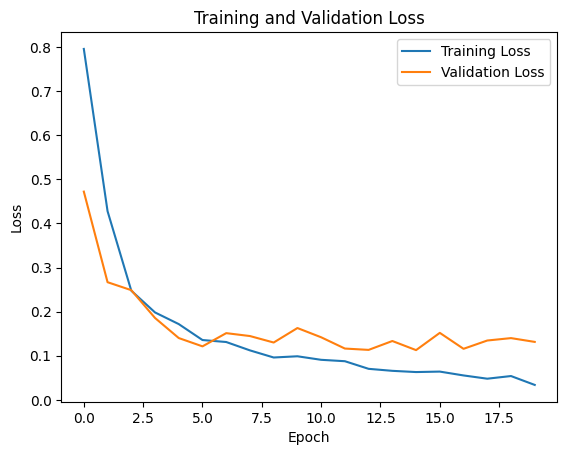

In [46]:

# Get the training history
history = model.fit(train_images, train_labels, epochs=20, batch_size=32, validation_data=(test_images, test_labels))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


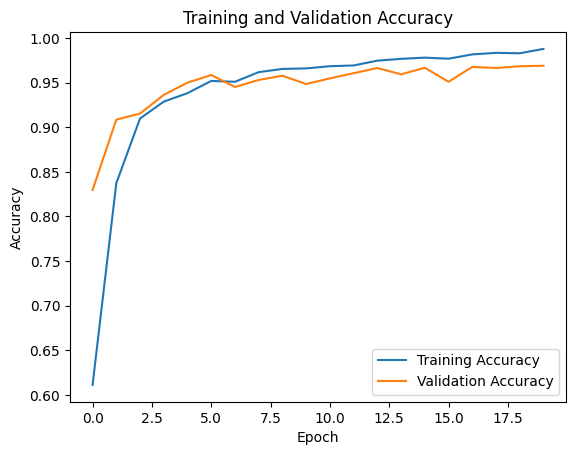

In [47]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [50]:


# Save the model to Google Drive
model.save("/content/drive/MyDrive/maize_classifier.keras")


124/124 [==============================] - 1s 6ms/step


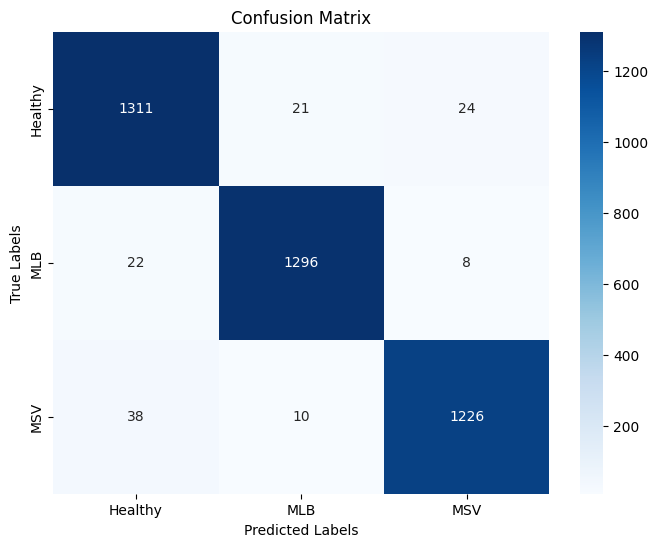

In [51]:

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

124/124 [==============================] - 1s 6ms/step


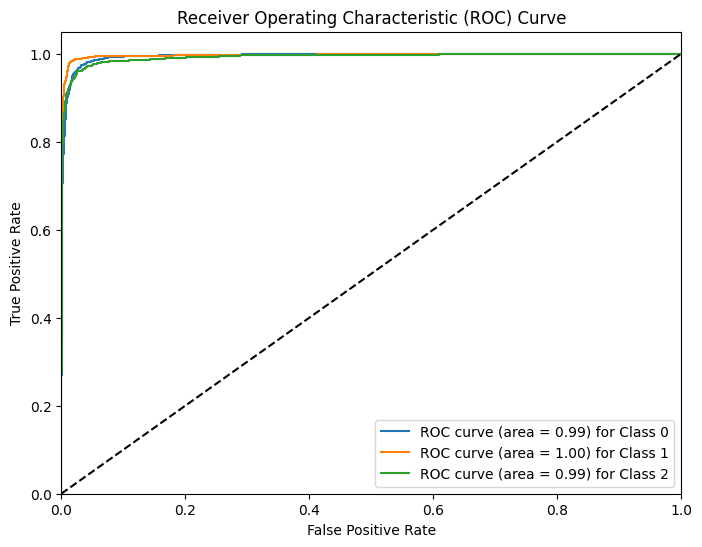

In [53]:
# Compute probabilities for each class
probabilities = model.predict(test_images)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = len(np.unique(test_labels))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((test_labels == i).astype(int), probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for Class {i}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


